In [118]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from statsmodels.stats.contingency_tables import mcnemar

from IPython.display import display

In [76]:
%matplotlib inline

# Wprowadzenie

Celem tego notebooka jest wprowadzenie do tematyki porównywania ze sobą klaysfikatorów. Nie jest to sprawa tak prosta, jak mogłoby się wydawać. 

Ważne źródła informacji:

> Dietterich, T. G. (1998) „Approximate statistical tests for comparing supervised classification learning  algorithms”, Neural computation. MIT Press, 10(7), ss. 1895–1923

> Demšar, J. (2006) „Statistical comparisons of classifiers over multiple data sets”, Journal of Machine learning research, 7(Jan), ss. 1–30.


Il. algorytmów \ Il. zbiorów danych | 1 | 1+ |
------------- | ------------- | ------------- |
2 | T-test różnicy metryki CV <br/> <br/> LUB <br/> <br/> Test McNemara | Test różnicy rang Wilcoxon'a |
2+ | T-test różnicy metryki CV <br/> <br/> LUB <br/><br/> Test Friedmana | Test Friedmana |

W czym jest problem? Dlaczego nie można zawsze stosować zwykłego t-testu różnicy metryki?

* Nie są spełnione założenia o normalności, stałej wariancji itp.
* Trzeba korygować p-wartości (np. metodą Bonferroniego albo podobną)
* Przede wszystkim - nie jest spełniony wymóg niezależności próbek

# Przygotowanie metryki

Metryka F1 dostarczana przez bibliotekę może działać tylko z dwiema klasami. Żeby używać jej dla więcej niż 2 klas trzeba to zrobić po swojemu :) 

In [2]:
score_f = lambda y_true, y_predicted: f1_score(y_true=y_true, y_pred=y_predicted, average='weighted')
f1_scorer = make_scorer(score_f)

# Sytuacja: 2 klasyfikatory, 1 zbiór danych (2x1)

In [4]:
data1 = pd.read_csv("./iris.csv")
data1.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [5]:
# Podział na zmienne egzogeniczne i endogeniczne

X, Y = data1.drop("species", axis=1), data1.species

In [6]:
display(X.head(3))

display(Y.head(3))

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


0    setosa
1    setosa
2    setosa
Name: species, dtype: object

In [7]:
# Utwórz obiekt klasyfikatora drzewa decyzyjnego i klasyfikatora Knn. Parametry dowolne

# niektóre klasyfikatory wymagają dodatkowego zapewnienia 
# deterministyczności. Trzeba to zawsze sprawdzać w dokumentacji
dt = DecisionTreeClassifier(random_state=555)
knn = KNeighborsClassifier()

## Zbieranie metryk

 Użyjemy 10-o krotnej walidacji krzyżowej

Kroki:

* Przygotowujemy *środowisko eksperymentalne* - podział danych ma być **deterministyczny** tzn. za każdym razem dawać taki sam wynik
* Używamy próbkowania **proporcjonalnego** tzn. zachowującego proporcje klas z oryginalnych danych

In [8]:
# Używamy obiektu, który zapewni nam deterministyczny podział danych
cv = StratifiedKFold(
    n_splits=10,        # Ustawiamy ilość losowań
    random_state=555    # Ustawiamy "ziarno" - dowolna liczba, ważne żeby pamiętać, czego się użyło :D 
)

### Wersja uproszczona

Ta wersja jest szybsza, także przydaje się podczas prototypowania wstępnego. Niestety, ma poważne ograniczenia:
1. nie pozwala na dokładne kontrolowanie, w jaki sposób działają klasyfikatory
2. nie pozwala liczyć dodatkowych metryk w trakcie działania
3. nie mamy wpływu na obsługę danych

In [9]:
# Używamy wbudowanej funkcji do policzenia wyników dla drzewa
dt_score_auto = cross_val_score(
    dt,                     # nasz klasyfikator
    X,                      # macierz zmiennych egzogenicznych
    Y,                      # wektor etykiet/klasy docelowej
    scoring=f1_scorer,      # nasza funkcja licząca metrykę F1
    cv=cv,                  # 10-o krotna walidacja
)

In [10]:
dt_score_auto

array([1.        , 0.93265993, 1.        , 0.93265993, 0.93265993,
       0.86666667, 0.93265993, 0.93265993, 1.        , 1.        ])

In [11]:
# Używamy wbudowanej funkcji do policzenia wyników dla Knn
knn_score_auto = cross_val_score(
    knn,                    # nasz klasyfikator
    X,                      # macierz zmiennych egzogenicznych
    Y,                      # wektor etykiet/klasy docelowej
    scoring=f1_scorer,      # nasza funkcja licząca metrykę F1
    cv=cv,                  # 10-o krotna walidacja
)

In [12]:
knn_score_auto

array([1.        , 0.93265993, 1.        , 1.        , 0.86111111,
       0.93265993, 0.93265993, 1.        , 1.        , 1.        ])

### Wersja zaawansowana

Wersja rekomendowana :) Pozwala nam na dokładne kontrolowanie liczonych metryk i przygotowywanie pewnych rzeczy "na boku". 

Kroki:

1. przygotowujemy deterministyczny podział danych - to mieliśmy zrobione już wyżej :)
2. przygotowujemy listę klasyfikatorów - jeśli mamy tylko dwa to sprawa jest łatwiejsza :) 
3. dzielimy dane k-razy
4. dla każdej iteracji i dla każdego klasyfikatora, liczymy jego trafność, zapisujemy wyniki i zgodność z wartościami oczekiwanymi

In [159]:
expected = []

dt_predictions_manual = []
dt_scores_manual = []

knn_predictions_manual = []
knn_scores_manual = []

In [160]:
# Krok 3 i 4:

# Manualnie dzielimy dane wg. deterministycznego próbkowania
for train_idx, test_idx in cv.split(X, Y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    # szkolimy klasfikatory
    # drzewo decyzyjne
    dt_fold = DecisionTreeClassifier(random_state=555)
    dt_fold.fit(X_train, y_train)
    
    # Knn
    knn_fold = KNeighborsClassifier()
    knn_fold.fit(X_train, y_train)
    
    # dokonujemy predykcji na zbiorze testowym
    dt_fold_predict = dt_fold.predict(X_test)
    knn_fold_predict = knn_fold.predict(X_test)
    
    # zapisujemy predykcje - to się nam bardzo przyda
    expected.append(y_test)
    dt_predictions_manual.append(dt_fold_predict)
    knn_predictions_manual.append(knn_fold_predict)
    
    # liczymy i zapisujemy trafności - to też się zaraz przyda
    dt_fold_score = f1_score(y_true=y_test, y_pred=dt_fold_predict, average='weighted')
    knn_fold_score = f1_score(y_true=y_test, y_pred=knn_fold_predict, average='weighted')
    
    dt_scores_manual.append(dt_fold_score)
    knn_scores_manual.append(knn_fold_score)
    

In [161]:
dt_scores_manual = np.array(dt_scores_manual)
knn_scores_manual = np.array(knn_scores_manual)

## Analiza metryk - 2x1

### Metoda 1 - t-test różnicy średnich metryk

Jest to *de facto* prosty, parametryczny test t-studenta różnicy średnich metryki.


$
\alpha \text{ zadany poziom ufności, zazw. 0.95 }
\text{n - liczba iteracji cv} \\
\mu_1 \text{  średnia wartość metryki klasyfikatora 1 w 10 próbach} \\
\mu_2 \text{  średnia wartość metryki klasyfikatora 2 w 10 próbach} \\
d_i \text{ różnica wartości metryki w i-tej iteracji } \\
\bar{\mu} = \mu_1 - \mu_2 \text{ różnica średnich wartości metryki klasyfikatorów} \\
t^* = \frac{\bar{\mu}  \sqrt{n}}{ \sqrt{ \frac{1}{n-1} \sum_{i=1}^{n-1} (d_i - \bar{\mu})^2 }} \\
t^* \approx t_{n-1, \alpha} \text{ statystyka ma rozkład t-studenta z n-1 stopniami swobody na poziomie α } \\
$

**Hipoteza zerowa** - różnica wartości metryk wynosi zero

**Hipoteza alternatywna** - różnica wartośći metryk jest różna od zera


Założenia testu:
* Mierzone wartości są wyrażone liczbowo na skali ciągłej
* Pobrane wartości są reprezentatywną próbką z populacji. **UWAGA: to założenie może być naruszone**
* Wartość różnic ma rozkład normalny. **UWAGA: to założenie może być naruszone **
* Powinna zostać użyta odpowiednio duża próbka, np. > 50. **UWAGA: to założenie może być naruszone**
* Wariancja różnic jest stała. **UWAGA: to założenie może być naruszone **

In [155]:
# piszemy to samodzielnie :) 
# Po kolei, tak jak w równaniach.
# Możemy wybrać albo wyniki automatyczne, albo manualne, bez znaczenia
alpha = 0.95
n = len(dt_scores_manual)

μ1 = np.mean(dt_scores_manual)
μ2 = np.mean(knn_scores_manual)

di = dt_scores_manual - knn_scores_manual

μ = np.mean(di)

t_star_numerator = μ * np.sqrt(n)
t_star_denominator = np.sqrt(  np.sum( (di - μ)**2 ) / (n-1)  )
t_star = t_star_numerator / t_star_denominator

# wyliczenie wartości krytycznej dla aktualnej statystyki
p_val = (1.0 - st.t.cdf(np.abs(t_star), df=n-1)) * 2.0

t_star, p_val

(-26.691467254196855, 7.034177684772658e-10)

In [156]:
# Prościej - za pomocą biblioteki. Wyniki są takie same
st.ttest_rel(dt_scores_manual, knn_scores_manual)

Ttest_relResult(statistic=-26.691467254196855, pvalue=7.034177828746016e-10)

Konkluzja - p-value jest większe od 0.05, czyli nie możemy odrzucić hipotezy zerowej

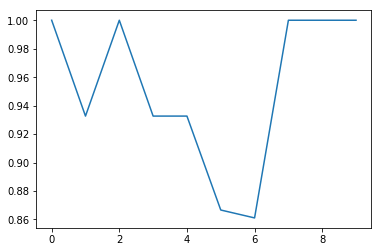

In [144]:
plt.plot(dt_scores_manual)

## Metoda 2 - Test McNemara

Czasami jest to lepsze rozwiązanie. Test jest nieparametryczny, czyli nie robi żadnych założeń. Jest przez to bardziej restrykcyjny, tzn. czasem trudno mu będzie wykryć istniejącą różnicę.

Opiera się na zbudowaniu tabeli pomyłek i współwystępowania wyników:



|    .                                        |             .                                   |
|----------------------------------------------|-------------------------------------------------|
| Klasyfikator 1 - źle Klasyfikator 2 - źle    | Klasyfikator 1 - źle Klasyfikator 2 - dobrze    |
| Klasyfikator 1 - dobrze Klasyfikator 2 - źle | Klasyfikator 1 - dobrze Klasyfikator 2 - dobrze |

|    .                                        |             .                                   |
|----------------------------------------------|-------------------------------------------------|
| n00    | n01    |
| n10 | n11 |

Test McNemara jest odpowiednikem testu Chi-kwadrat różnicy pomiędzy wartościami zaobserwowanymi a wartościami oczekiwanymi.

Jeśli założymy, że nie ma różnicy pomiędzy klasyfikatorami, to spodziwalibyśmy się następującego układu:

|    .                                        |             .                                   |
|----------------------------------------------|-------------------------------------------------|
| n00    | (n01 + n10)/2    |
| (n01 + n10)/2 | n11 |


Czyli gdzie proporcja złych klasyfikacji w przypadku A i B jest identyczna. Czy tak jest w istocie? Sprawdza to test McNemara.

$
\alpha \text{ zadany poziom ufności} \\
\chi^2_{mcnemar} = \frac{(|n_{01} - n_{10}| -1)^2}{n_{01} + n_{10}} \\
\chi^2_{mcnemar} \approx \chi^2_{1, \alpha}
$

**Hipoteza zerowa** - rzeczywista wartośc macierzy pomyłek jest taka sama, jak wartośc oczekiwana

**Hipoteza alternatywna** - rzeczywista wartość macierzy pomyłek różni się od oczekiwanej

**Zazwyczaj tej metody możemy użyć tylko z jednym podziałem danych, aczkolwiek można to objeść :D**

In [145]:
# Bierzemy wyniki tylko z piątego podziału. Możemy wziąć dowolny inny
dt_predictions5 = dt_predictions_manual[5]
knn_predictions5 = knn_predictions_manual[5]
y_expected5 = expected[5]

In [146]:
# Sprawadzamy, czy drzewo decyzyjne się pomyliło?
dt_was_ok = dt_predictions5 == y_expected5

# Sprawdzamy, czy knn się pomylił?
knn_was_ok = knn_predictions5 == y_expected5

In [147]:
# Robimy tabelę zestawiającą oba klasyfikatory
two_cls = pd.DataFrame({'dt': dt_was_ok, 'knn':knn_was_ok})
two_cls.head(4)

,dt,knn
25,True,True
26,True,True
27,True,True
28,True,True


In [148]:
# Podsumowujemy ją - trick polegający na iloczynie diadycznym
# rzutujemy na wartości liczbowe
two_cls_asint = two_cls.astype(int)

conf_matrix = two_cls_asint.T.dot(two_cls_asint)
conf_matrix

,dt,knn
dt,13,13
knn,13,14


In [149]:
# Liczymy wartośc statystyki - tym razem z biblitoeki :D 

result = mcnemar(conf_matrix, exact=True)
print("Statystyka chi-kwadrat", result.statistic, "p-val:", result.pvalue)

Statystyka chi-kwadrat 13.0 p-val: 1.0


## Zadania dla sytuacji 2:

* Spróbuj zmienić parametry drzewa decyzyjnego i klasyfikatora Knn w przykładzie tak, aby wyniki były inne. Sprawdzaj "na oko" i statystycznie. Kiedy różnica będzie statystycznie istotna?
* Przeprowadź porównanie klasyfikatorów na zbiorze Adult, przygotowanym poniżej.

In [165]:
adults = pd.read_csv("./adult.csv")

In [175]:
X_adults, Y_adults = adults.drop("earnings", axis=1), adults.earnings

In [176]:
Y_adults.unique()

array(['<=50K', '>50K'], dtype=object)

In [177]:
X_adults = pd.get_dummies(X_adults)
Y_adults = Y_adults.replace("<=50K", 0).replace(">50K", 1)

In [184]:
# Stwórz i porównaj dwa klasyfikatory